#ЛР №7

Основные понятия ООП. Наследование. Полиморфизм.

#Основное задание




Написать базовый класс BaseProcessing, который предоствляет интерфейс для обработки данных (сигналы и изображения).

В классе BaseProcessing реализовать следующие абстрактные методы:

**Интерфейс BaseProcessing**

* `_filtering()` — осуществляет фильтрацию (абстрактный метод).
* `visualize()` — визуализирует сигнал/изображение (абстрактный метод).
* `get_shape()` — возвращает размерность (абстрактный метод).
* `feature_extraction()` — возвращает вектор признаков (абстрактный метод).


Класс SignalProcessing наследует BaseProcessing и переопределяет его методы

**Интерфейс SignalProcessing** (код для реализации отдельных методов ниже)

* _конструктор_ — принимает на вход путь к файлу и создает соответствующие поля
* `_filtering(signal)` — осуществляет фильтрацию сигнала (возвращает отфильтрованный сигнал).
* `visualize()` — визуализирует сигнал.
* `get_shape()` — возвращает длину сигнала.
* `_signal_find_peaks(signal, find_peaks_parametres)` — находит точки максимума сигнала и возвращает их в виде списка.
* `_calculate_RR_intervals()` — производит расчет длительности RR интервалов (попарных расстояний между пиками) и возвращает длины RR интервалов в виде списка.
В этом методе вызываются методы _filtering и _signal_find_peak.
* `feature_extraction()` — возвращает статистические характеристики RR интервалов на записи ECG - среднее, std, min, max (в виде списка - вектор признаков). В этом методе вызывается метод _calculate_RR_intervals.

Класс ImageProcessing наследует BaseProcessing и переопределяет его методы

**Интерфейс ImageProcessing** (код для реализации отдельных методов из предыдущей лабораторной)

* _конструктор_ — принимает на вход путь к файлу и создает соответствующие поля
* `_filtering(image)` — применяет фильтр Гаусса к изображению (возвращает отфильтрованное изображение).
* `visualize()` — визуализирует изображение.
* `get_shape()` — возвращает размерность изображения.
* `_create_gabor_filter(parameters)` — создает и возвращает фильтр Габора с заданными параметрами.
* `feature_extraction()` — применяет _filtering() к изображению, считает признаки с _create_gabor_filter(parameters)и возвращает вектор признаков: среднее и дисперсию по изображению.

*можно добавить свои методы


Изображение и синал находятся в папке

In [2]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.0 MB/s eta 0:00:00


In [4]:
  !pip install heartpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.0 MB/s eta 0:00:00


In [7]:
#Необходимые модули и функции
from scipy.ndimage import gaussian_filter
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import pandas as pd
import wfdb
import heartpy as hp
from scipy.signal import find_peaks
from abc import ABC, abstractmethod

<ipython-input-7-6d7c25b69835>:7: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
class BaseProcessing:
    @abstractmethod
    def _filtering(self):
        pass
    @abstractmethod
    def visualize(self):
      pass

    @abstractmethod
    def get_shape(self):
        pass

    @abstractmethod
    def feature_extraction(self):
        pass

In [10]:
class SignalProcessing(BaseProcessing):
    def __init__(self, sig_dict):
        self.path_signal = sig_dict['signal']
        self.parameters = sig_dict['parameters']
        self.sig = pd.read_csv(self.path_signal)['MLII']

    def _filtering(self):
        filtered = hp.filter_signal(self.sig, **self.parameters['filtration'])
        return filtered

    def visualize(self, *sig):
        for i in sig:
          if type(i) == tuple:
            plt.plot(i[0], i[1])
          else:
            plt.plot(i)
        plt.show()

    def get_shape(self):
        return len(self.sig)

    def _signal_find_peaks(self):
        filtered = self._filtering()
        peaks, _ = find_peaks(filtered, **self.parameters['find_peaks'])
        return list(peaks)

    def _calculate_RR_intervals(self):
        peaks = self._signal_find_peaks()
        RR_int = []
        for i in range(1, len(peaks)):
            RR_int.append(peaks[i] - peaks[i-1])
        return RR_int

    def feature_extraction(self):
        RR_int = self._calculate_RR_intervals()
        return [np.mean(RR_int), np.std(RR_int), min(RR_int), max(RR_int)]

In [11]:
class  ImageProcessing(BaseProcessing):
    def __init__(self, img_dict):
        self.path_image = img_dict['image']
        self.parameters = img_dict['parameters']
        self.image = cv2.imread(self.path_image, cv2.IMREAD_GRAYSCALE)

    def _filtering(self):
        image_filtered = ndi.gaussian_filter(self.image, .5)
        return image_filtered

    def plot_image_filtration(self):
        image_filtered = self._filtering()
        plt.imshow(image_filtered, cmap = 'gray')
        plt.show()

    def visualize(self):
        plt.imshow(self.image)
        plt.show()

    def get_shape(self):
        return self.image.shape

    def _create_gabor_filter(self):
        kernel = np.real(gabor_kernel(**self.parameters))
        return kernel

    def plot_image_gabor(self):
        conv = ndi.convolve(self._filtering(), self._create_gabor_filter(), mode = 'wrap')
        plt.imshow(conv)
        plt.show()

    def feature_extraction(self):
        conv = ndi.convolve(self._filtering(), self._create_gabor_filter(), mode = 'wrap')
        return [conv.mean(), conv.var()]

In [13]:
ecg = {'signal': '/content/drive/MyDrive/Colab Notebooks/ecg.csv',
       'parameters': {
           'filtration': {
               'cutoff': [0.75, 3.5],
               'sample_rate': 100,
               'order': 3,
               'filtertype': 'bandpass'},
           'find_peaks': {
               'height': 20}}
       }
ecg = SignalProcessing(ecg)

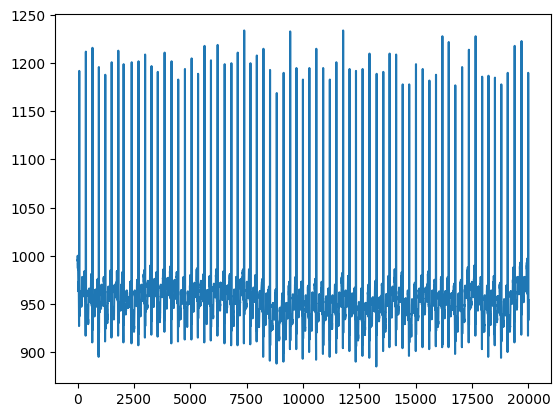

In [14]:
ecg.visualize(ecg.sig)

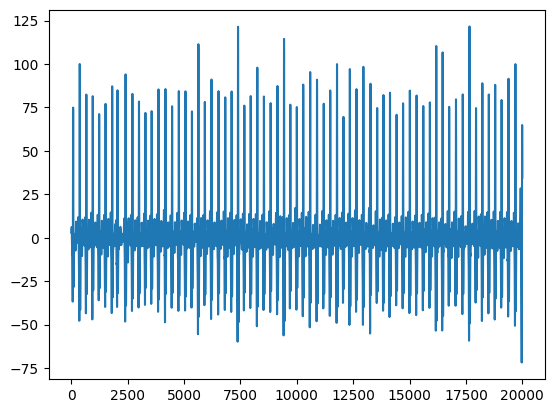

In [15]:
filt = ecg._filtering()
ecg.visualize(filt)

In [16]:
ecg.get_shape()

20000

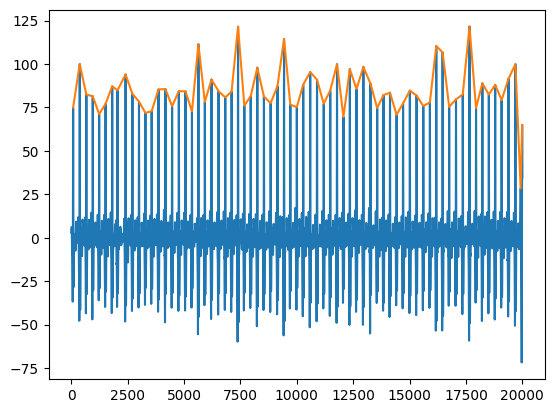

In [17]:
peaks = ecg._signal_find_peaks()
ecg.visualize(filt, (peaks, filt[peaks]))

In [18]:
print(ecg._calculate_RR_intervals())

[293, 293, 284, 284, 284, 294, 236, 358, 303, 292, 285, 277, 303, 308, 295, 299, 295, 287, 287, 284, 296, 313, 297, 282, 285, 279, 283, 293, 293, 298, 304, 290, 279, 288, 284, 309, 303, 298, 288, 301, 285, 284, 295, 305, 317, 295, 280, 289, 292, 288, 300, 299, 297, 293, 283, 282, 290, 303, 300, 299, 290, 280, 287, 282, 285, 307, 305, 233, 66]


In [19]:
print(ecg.feature_extraction())

[288.6231884057971, 31.077323597890175, 66, 358]


In [ ]:
image = {'image': '/content/drive/MyDrive/Python-BMT-main/Python-BMT-main/Seminar7/chest-xray.tif',
         'parameters' : {
             'frequency': 0.25,
             'theta' : np.pi,
             'sigma_x' : 1,
             'sigma_y' : 1 }
         }
image = ImageProcessing(image)

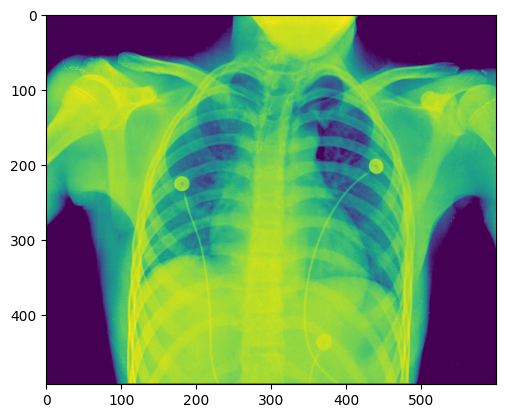

In [ ]:
image.visualize()

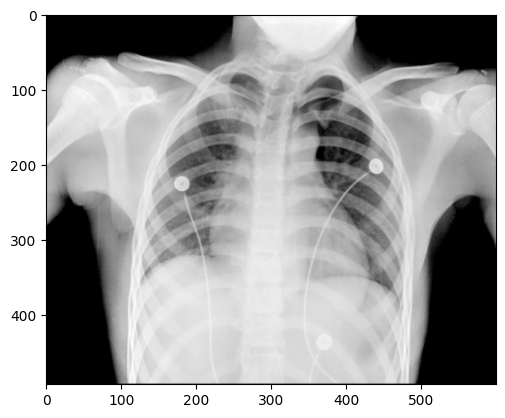

In [ ]:
image.plot_image_filtration()

In [ ]:
image.get_shape()

(493, 600)

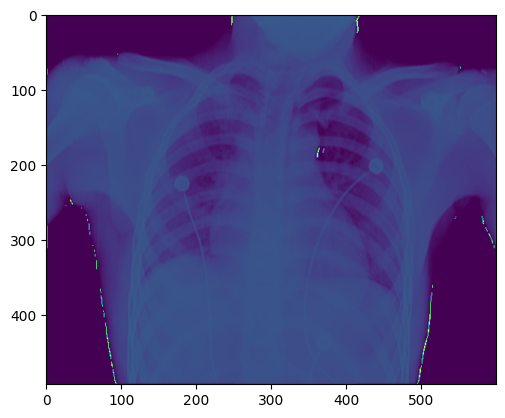

In [ ]:
image.plot_image_gabor()

In [ ]:
image.feature_extraction()

[41.113566599053414, 670.1179849805205]

###Для сигнала

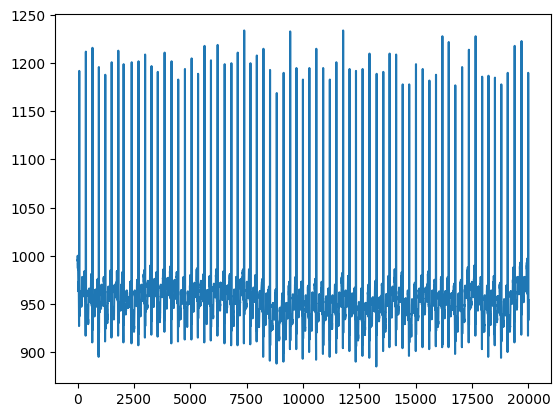

In [ ]:
#загрузка сигнала из .csv файла с pandas
df = pd.read_csv('/content/drive/MyDrive/Python-BMT-main/Python-BMT-main/Seminar7/ecg.csv')
plt.plot(df['MLII'])
plt.show()

In [ ]:
#размерность
df['MLII'].shape

(20000,)

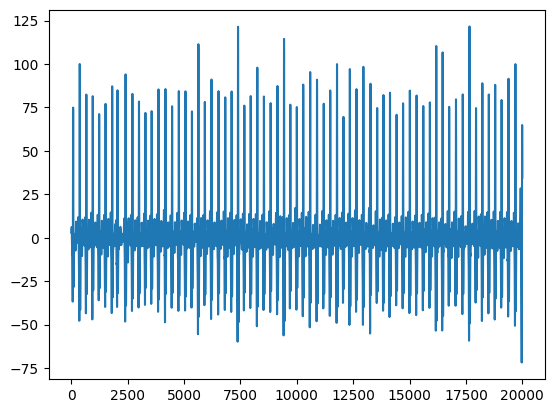

In [ ]:
#фильтрация сигнала с библиотекой heartpy
filtered = hp.filter_signal(df['MLII'], cutoff = [0.75, 3.5], sample_rate = 100, order = 3, filtertype='bandpass')
plt.plot(filtered)
plt.show()

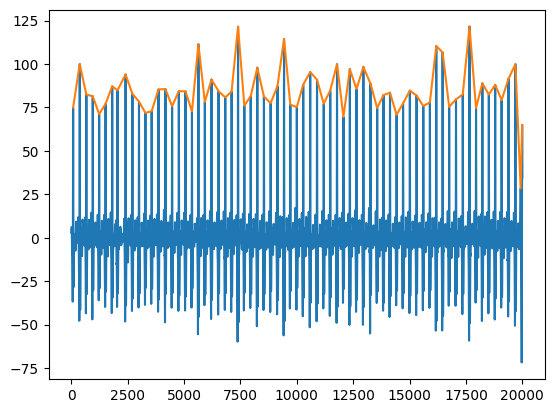

In [ ]:
#поиск точек максимума с библиотекой scipy
peaks, _ = find_peaks(filtered, height=20)
plt.plot(filtered)
plt.plot(peaks, filtered[peaks])
plt.show()

###Для изображения

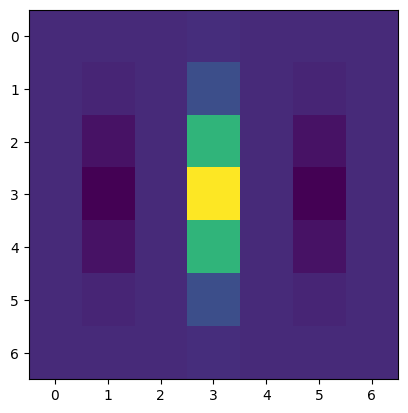

In [ ]:
#Создание фильтра Габора
frequency = 0.25
theta = np.pi
sigma = 1
kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
plt.imshow(kernel)
plt.show()

In [ ]:
#Чтение изображения
image = cv2.imread('/content/drive/MyDrive/Python-BMT-main/Python-BMT-main/Seminar7/chest-xray.tif', cv2.IMREAD_GRAYSCALE)
#Применение филтра Гаусса к изображению
image_filtered = ndi.gaussian_filter(image, .5)

In [ ]:
#Размерность изображения
image.shape

(493, 600)

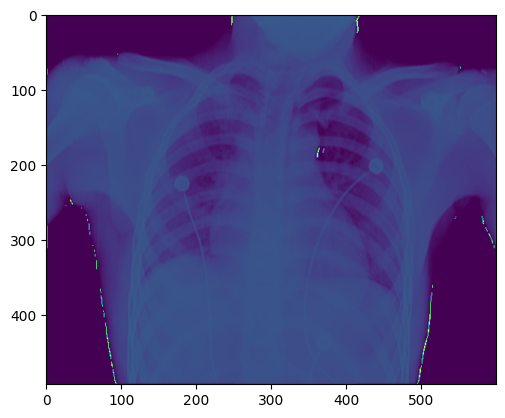

In [ ]:
#свертка изображения с фильтром Габора
conv = ndi.convolve(image_filtered, kernel, mode='wrap')
plt.imshow(conv)
plt.show()

In [ ]:
#Расчет вертора признаков изображения
feats = [conv.mean(), conv.var()]

#Задача * "Классификатор"

В классе BaseProcessing реализовать метод:
* `get_predict(features, etalons_features)` — метод, в котором осуществляется классификация на основе рассчета Евклидова расстояния между features изображения или сигнала и эталонными значениями признаков (etalons_features) каждого класса изображений или сигналов. Классификация осуществляется следующим образом: полученные Евклидовы расстояния ранжируются в порядке возрастания. Чем меньше Евклидово расстояние, тем более похожим на эталонное изображение считается наше изображение. Выбирается индекс соответствуюших эталонных признаков, которые и являются номером класса. Эталонных класса 2, т.е. возвращается 0 или 1, т.е. класс к которому относится изображение/сигнал.

Классы SignalProcessing и ImageProcessing наследуют реализованный метод get_predict.

Продемонстрировать вызов метода в классах

Эталонные признаки (etalons_features) могут подаются в формате списка:
[[1, 8], [5, 0.5]] -> тогда класс вернуть по индексу

или в формате словаря [{'features': [1, 8], 'class': 0}, {'features': [5, 0.5], 'class': 1}]

#Задача ***  "Словарь-директория" в папке

